<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/Speaker_Classification_gfcc_v1_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages:

In [0]:
#!pip install --upgrade tensorflow-gpu

In [1]:
!pip install soundfile
!pip install spafe

     |████████████████████████████████| 81kB 2.5MB/s 


In [2]:
import tensorflow
tensorflow.test.gpu_device_name() 

'/device:GPU:0'

# Import Data from Drive :

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj/view?usp=sharing'
#fluff, id = link.split('=')
id = '1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj'
print (id) 

1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LibriSpeech.zip')  

# Extracting Data from (.)rar

In [7]:
!pip install patool

     |████████████████████████████████| 81kB 2.4MB/s 


In [8]:
import os
os.listdir()

['.config', 'LibriSpeech.zip', 'adc.json', 'sample_data']

In [9]:
%%time
import patoolib
patoolib.extract_archive("LibriSpeech.zip")

patool: Extracting LibriSpeech.zip ...
patool: running /usr/bin/7z x -o./Unpack_l2tiuh9y -- LibriSpeech.zip
patool: ... LibriSpeech.zip extracted to `LibriSpeech'.
CPU times: user 9.53 ms, sys: 21 ms, total: 30.6 ms
Wall time: 600 ms


# Audio Data Preprocessing :

In [10]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [0]:
from spafe.features.lpc import lpc
from spafe.features.gfcc import gfcc
cep = 20
def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=cep, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

def lpcc_(sig,fs):
  lpccs = lpc(sig, fs=fs, num_ceps=cep, pre_emph=0, 
                       pre_emph_coeff=0.97, win_type='hamming', 
                       win_len=0.025, win_hop=0.01, do_rasta=True, 
                       dither=1)
  return lpccs

def gfcc_(sig,fs):
  gfccs = gfcc(sig, fs=fs, num_ceps=cep, pre_emph=0, 
             pre_emph_coeff=0.97, win_len=0.025, win_hop=0.01, win_type='hamming', 
             nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', 
             dct_type=2, use_energy=False, lifter=22, normalize=1)
  return gfccs

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [0]:
from pathlib import Path
len_audio = 148
def s2c(mfcc=False,lpcc=False,gfcc=False):
    x,y=[],[]
    data = np.empty([1,len_audio,cep])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    #for file in tqdm(glob.iglob('/LibriSpeech/test-clean//**/*.flac', recursive=True)):
    for file in tqdm(Path('LibriSpeech/dev-clean').glob('**/*.flac')):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        if gfcc:
            feature = gfcc_(signal,sr)

        quotient = int(feature.shape[0]/len_audio)
        end_index = feature.shape[0]-(feature.shape[0]%len_audio)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,len_audio,cep)) #b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label

In [15]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 15.7 µs


In [16]:
%%time
x,y = s2c(mfcc=False,lpcc=False,gfcc=True)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

661it [00:22, 29.48it/s]

(2950, 148, 20) (2950,)
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
CPU times: user 24.3 s, sys: 18.4 s, total: 42.7 s
Wall time: 22.4 s


In [17]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)
import keras

y_binary = keras.utils.to_categorical(y, num_classes = 10)
#y_binary = np.asarray(list(map(int,y)))
print(y_binary)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

(2950, 148, 20, 1)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Training shape: (2360, 148, 20, 1), Training label shape : (2360, 10)
Training shape: (590, 148, 20, 1), Training label shape : (590, 10)


# Creating CNN Architecture :

In [18]:
%tensorflow_version 2.x
import tensorflow 
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [19]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
                                                           #optimizer=keras.optimizers.Adam()
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 16, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 8, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 6, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 2, 64)         0

In [20]:
%%time
epoch = 500
batch_sizes = 16
from tensorflow.python.keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=1)



history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
                    validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint])


Epoch 00320: val_loss did not improve from 0.07652

Epoch 00321: val_loss did not improve from 0.07652

Epoch 00322: val_loss did not improve from 0.07652

Epoch 00323: val_loss did not improve from 0.07652

Epoch 00324: val_loss did not improve from 0.07652

Epoch 00325: val_loss did not improve from 0.07652

Epoch 00326: val_loss did not improve from 0.07652

Epoch 00327: val_loss did not improve from 0.07652

Epoch 00328: val_loss did not improve from 0.07652

Epoch 00329: val_loss did not improve from 0.07652

Epoch 00330: val_loss did not improve from 0.07652

Epoch 00331: val_loss did not improve from 0.07652

Epoch 00332: val_loss did not improve from 0.07652

Epoch 00333: val_loss did not improve from 0.07652

Epoch 00334: val_loss did not improve from 0.07652

Epoch 00335: val_loss did not improve from 0.07652

Epoch 00336: val_loss did not improve from 0.07652

Epoch 00337: val_loss did not improve from 0.07652

Epoch 00338: val_loss did not improve from 0.07652

Epoch 00339

In [21]:
#Loading the model that performed the best on the validation set
model.load_weights('Model.v_2.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(x_test, y_test, batch_size=16, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

37/37 [==============================] - 0s 5ms/step - loss: 0.0574 - accuracy: 0.9847
Accuracy on test data: 98.47%


# Plotting plot :



1.   **accuracy_plot()** : This function plot graph between train accuracy vs validation/test accuracy
2.   **loss_plot():** This function plot graph between train loss vs validation loss



In [0]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    #plt.figure(figsize=(12,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

def loss_plot(history):
    #plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

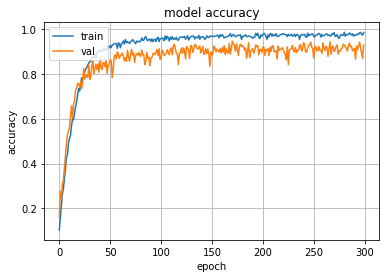

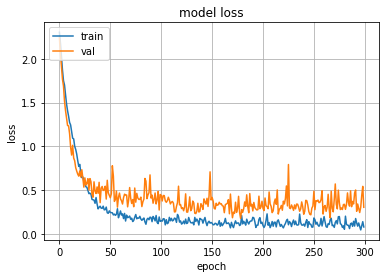

In [26]:

accuracy_plot(history)
loss_plot(history)

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# VGG16

In [0]:
"""model1 = Sequential()
model1.add(Conv2D(input_shape=(x.shape[1],x.shape[2],1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=512, kernel_size=(3,3), pāadding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=128,activation="relu"))
model1.add(Dense(units=128,activation="relu"))
model1.add(Dense(units=40, activation="softmax"))
print(model1.summary())
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
"""

In [0]:
"""%%time
from keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model1.fit(x_train, y_train, batch_size=32, epochs=200, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])"""

In [0]:
"""# Loading the model that performed the best on the validation set
model1.load_weights('Model.v_2.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))"""